# POKER HAND CLASSIFICATION
## 很有事的想用神經網路做撲克牌的分類(用一般的邏輯分類應該會一定準吧XD)
從 UCI 的 Repository 取得撲克牌的資料，並嘗試分成以下十個分類
0. Nothing 打牌時最不想拿到的可是都會拿到的
1. One Pair 僅一個對子
2. Two Pair 僅兩個對子
3. Three of a Kind 僅三張數字一樣，剩下兩張不是對子
4. Straight 順子
5. Flush 同花非順子
6. Full House 三張數字一樣+一個對子，是叫ㄌㄨˊ 嗎?
7. Four of a Kind 鐵支?
8. Straight Flush 同花順
9. Royal Flush \[10, J, Q, K, A\] + 同花

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydot

%env KERAS_BACKEND = tensorflow
%matplotlib inline

env: KERAS_BACKEND=tensorflow


In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, concatenate, add
#from keras.optimizers import SGD
from keras.utils import np_utils
from keras import losses
from keras import optimizers

Using TensorFlow backend.


## Poker Hand Dataset 的 csv 可以從 [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Poker+Hand) 下載到

In [3]:
pd_poker_test = pd.read_csv('./Poker_Hand/poker-hand-testing.data',
                         names = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'CLASS'])
pd_poker_train = pd.read_csv('./Poker_Hand/poker-hand-training-true.data',
                         names = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'CLASS'])

# CLASS:    0:Nothing Specical
#           1:One Pair
#           2:Two Pairs
#           3:Three of a Kind
#           4:Straight
#           5:Flush
#           6:Full House
#           7:Four of a Kind
#           8:Straight Flush
#           9:Royal Flush

In [4]:
pd_poker_test.tail(10)
#pd_poker_train.head(10)

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,CLASS
999990,2,12,4,3,1,3,3,5,3,2,1
999991,1,4,4,8,4,5,3,9,2,1,0
999992,1,9,3,6,2,8,3,5,2,9,1
999993,1,12,3,9,3,6,1,3,1,9,1
999994,3,7,1,6,4,12,2,1,1,4,0
999995,3,1,1,12,2,9,4,9,2,6,1
999996,3,3,4,5,2,7,1,4,4,3,1
999997,1,11,4,7,3,9,1,13,2,7,1
999998,3,11,1,8,1,1,3,13,2,8,1
999999,2,5,2,9,4,9,2,3,3,3,2


In [5]:
x_test = pd_poker_test.iloc[:,0:10].values
x_train = pd_poker_train.iloc[:,0:10].values

y_test = pd_poker_test['CLASS'].values
y_train = pd_poker_train['CLASS'].values

## 方法一. 做完簡單的預處理(normalization, one-hot encoding) 後直接訓練

### 預處理

In [6]:
x_test_normalized = np.zeros(x_test.shape)
x_train_normalized = np.zeros(x_train.shape)

for suit in range(0,10,2):
    x_test_normalized[:, suit] = x_test[:, suit]/4.0
    x_train_normalized[:, suit] = x_train[:, suit]/4.0
for card in range(1,11,2):
    x_test_normalized[:, card] = x_test[:, card]/13.0
    x_train_normalized[:, card] = x_train[:, card]/13.0

y_test_one_hot = np_utils.to_categorical(y_test,10)
y_train_one_hot = np_utils.to_categorical(y_train,10)

### 設定空的學習機

In [7]:
model_1st = Sequential()

first_layer = [ Dense(400, input_dim = 10), Activation('relu') ]
second_layer = [ Dense(400), Activation('relu') ]
output_layer = [ Dense(10), Activation('softmax')]

model_1st = Sequential(first_layer + second_layer + output_layer)

model_1st.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               4400      
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
activation_2 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                4010      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 168,810
Trainable params: 168,810
Non-trainable params: 

In [8]:
model_1st.load_weights('./Poker_Hand_Machines/poker_hand_1st_machine_weights.h5')
model_1st.compile(optimizers.sgd(lr=0.05), loss = losses.categorical_crossentropy, metrics = ['acc'])
#model_1st_history = model_1st.fit(x_train_normalized,y_train_one_hot, batch_size=100, epochs=1000)

In [9]:
score_train = model_1st.evaluate(x_train_normalized, y_train_one_hot)
score_test = model_1st.evaluate(x_test_normalized, y_test_one_hot)
y_predict = model_1st.predict_classes(x_test_normalized)

1000000/1000000 [==============================] - 39s 39us/step


In [10]:
print(f'For Training Data: Loss = {score_train[0]:.6f}; Accuracy = {100*score_train[1]:.6f}%')
print(f'For Testing Data: Loss = {score_test[0]:.6f}; Accuracy = {100*score_test[1]:.6f}%')

For Training Data: Loss = 0.004561; Accuracy = 100.000000%
For Testing Data: Loss = 0.105137; Accuracy = 97.002000%


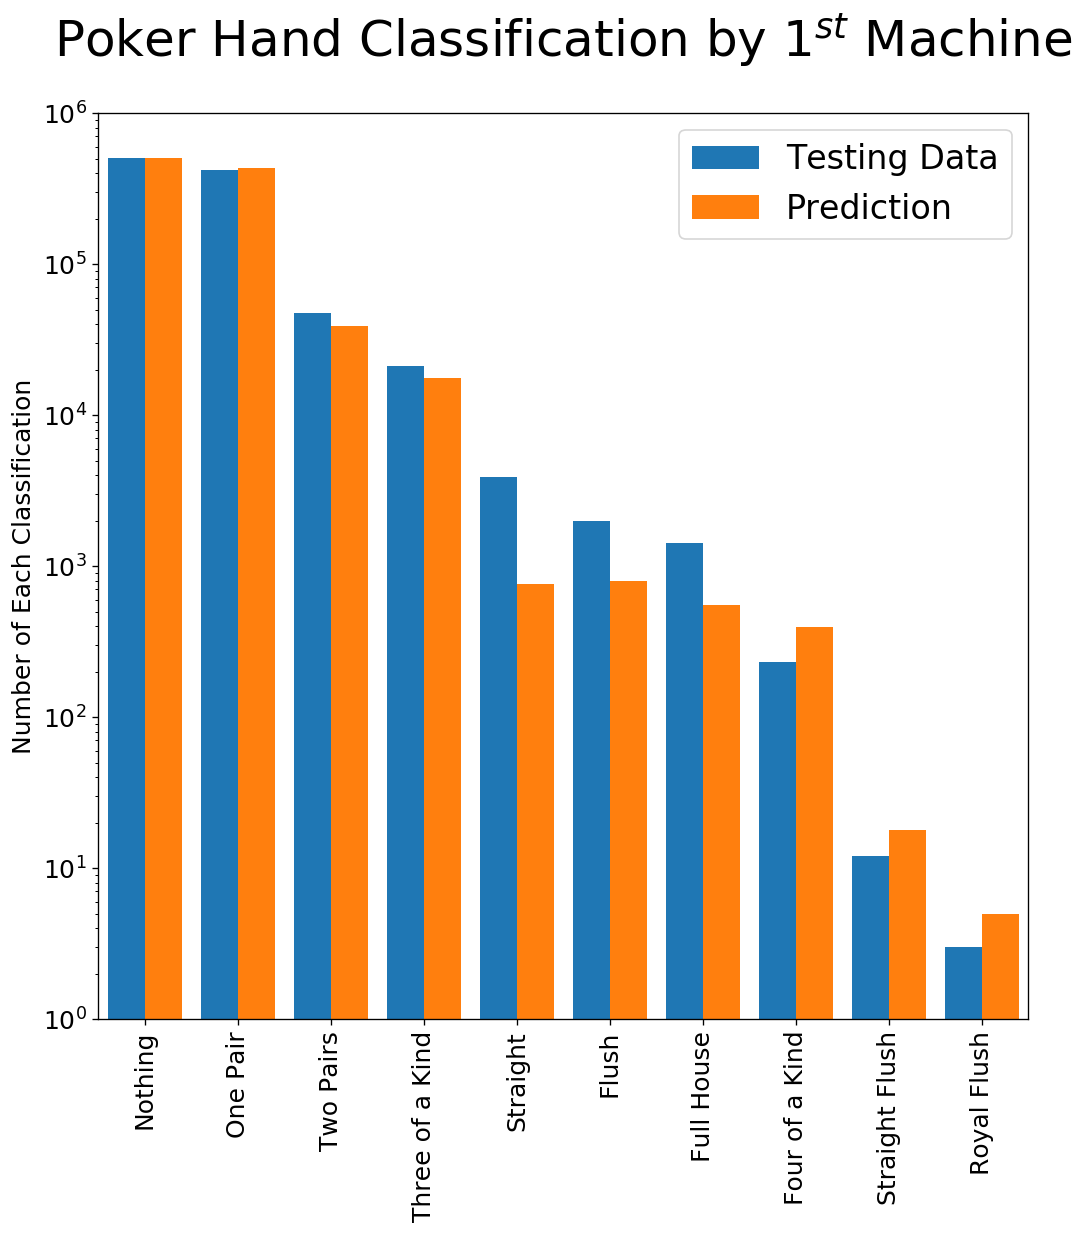

In [11]:
figure = plt.figure(figsize=(10,10), dpi =120)
ax = plt.hist([y_test, y_predict], bins=np.arange(-0.5,10.5,1.0), log=True, align='mid')
ax = plt.xlim(-.5,9.5,1.0)
ax = plt.ylim(1,1e6)
ticks = np.arange(0, 10, 1.0)
labels = ['Nothing','One Pair','Two Pairs', 'Three of a Kind', 'Straight', 'Flush', 'Full House', 'Four of a Kind', 'Straight Flush', 'Royal Flush']
ax = plt.xticks(ticks, labels, rotation = 'vertical', fontsize=15)
ax = plt.yticks(fontsize=15)
ax = plt.ylabel('Number of Each Classification', fontsize=15)
ax = plt.legend(['Testing Data','Prediction'], prop={'size': 20})
ax = plt.title('Poker Hand Classification by $1^{st}$ Machine', fontsize=30, y= 1.05)
plt.show()

In [12]:
A = range(0,10)
name = ['0. Nothing','1. One Pair','2. Two Pairs', '3. Three of a Kind', '4. Straight', '5. Flush', '6. Full House', '7. Four of a Kind', '8. Straight Flush', '9. Royal Flush']
category = dict(zip(A,name))
name_test = []
name_predict = []
for i in range(0,len(y_test)):
    name_test.append(category[y_test[i]])
    name_predict.append(category[y_predict[i]])
name_test = np.array(name_test)
name_predict = np.array(name_predict)

pd.crosstab(name_test, name_predict, rownames=['true classification'],colnames=['predict classification'])

predict classification,0. Nothing,1. One Pair,2. Two Pairs,3. Three of a Kind,4. Straight,5. Flush,6. Full House,7. Four of a Kind,8. Straight Flush,9. Royal Flush
true classification,,,,,,,,,,
0. Nothing,500802,367,0,0,28,12,0,0,0,0
1. One Pair,89,421420,539,24,191,182,0,31,17,5
2. Two Pairs,0,12603,32135,2438,0,1,243,202,0,0
3. Three of a Kind,0,813,5480,14442,0,0,225,161,0,0
4. Straight,2478,864,0,0,542,0,0,0,1,0
5. Flush,1398,3,0,0,0,595,0,0,0,0
6. Full House,0,0,938,401,0,0,84,1,0,0
7. Four of a Kind,0,0,4,226,0,0,0,0,0,0
8. Straight Flush,4,2,0,0,2,4,0,0,0,0


In [13]:
#model_1st_json = model_1st.to_json()
#open('./Poker_Hand_Machines/poker_hand_1st_machine','w').write(model_1st_json)
#model_1st.save_weights('./Poker_Hand_Machines/poker_hand_1st_machine_weights.h5')

### 雖然 Histogram 看起來還不差，看了 confusion matrix 可以發現非對角線的元素有點多...

## 方法二. 來改善看看，把預處理做更好一點吧~
因為花色會涉及的分類只有Flush, Straight Flush跟Royal Flush, 可以事先把花色拉出來不用給機器學，等機器分類完我們再用工人智慧進一步分類。
不考慮花色後， Flush 就會被併到 Nothing， Straight Flush 和 Royal Flush 則被併到 Straight。<br>
不過為了最後再加入花色後能把 Royal Flush 從 Straight 裡分出來，可以另外創一個分類是 10, J, Q, K, Ace 的Staight，到時候這類中如果不是同花的就歸類到普通的 Straight，同花就是 Royal Flush。
### 所以我們要做的預處理是:
1. 把同花標記下來(做成一個array: y_test_flush)

In [14]:
y_test_flush = np.zeros((len(y_test)))
y_test_flush[(pd_poker_test['S1']==pd_poker_test['S2']) & (pd_poker_test['S2']==pd_poker_test['S3']) \
             & (pd_poker_test['S3']==pd_poker_test['S4']) & (pd_poker_test['S4']==pd_poker_test['S5'])]= 1

# Checking the card hands of same suit is same as Flush + Straight Flush + Royal Flush
#y_test_flush.sum()
#pd_poker_test['CLASS'][pd_poker_test['CLASS']==5].sum()/5.0 + pd_poker_test['CLASS'][pd_poker_test['CLASS']==8].sum()/8.0 + \
#pd_poker_test['CLASS'][pd_poker_test['CLASS']==9].sum()/9.0

2. 把 Straight 裡 10, J, Q, K, Ace的排組抽出來跟 Royal Flush 合併
3. 把 Flush 跟 Nothing Special 合併
4. 重新編號成 y_card_train 和 y_card_test:
<br>    #0 Nothing Special + #5 Flush => #0. Nothing
<br>    #1 One Pair => #1 One Pair
<br>    #2 Two Pairs => #2 Two Pairs
<br>    #3 Three of a Kind => #3 Three of a Kind
<br>    #4 Straight + #8 Straight Flush => #4. Straight except 10, J, Q, K, Ace
<br>    #6 Full House => #5 Full House
<br>    #7 Four of a Kind => #6 Full of a Kind
<br>    #9 Royal Flush + #4 Straight => #7. 10, J, Q, K, Ace

In [15]:
y_card_train = np.zeros((len(y_train)))
y_card_test = np.zeros((len(y_test)))

for i in range (0,len(y_train)):
    if y_train[i]== 4:
        if x_train[i].min()==1 and x_train[i].max()==13:
            y_card_train[i] = 7
        else:
            y_card_train[i] = 4
    elif y_train[i] == 5:
        y_card_train[i] = 0
    elif y_train[i] == 6:
        y_card_train[i] = 5
    elif y_train[i] == 7:
        y_card_train[i] = 6
    elif y_train[i] == 8:
        y_card_train[i] = 4
    elif y_train[i] == 9:
        y_card_train[i] = 7
    else:
        y_card_train[i] = y_train[i]
        
for i in range (0,len(y_test)):
    if y_test[i]== 4:
        if x_test[i].min()==1 and x_test[i].max()==13:
            y_card_test[i] = 7
        else:
            y_card_test[i] = 4
    elif y_test[i] == 5:
        y_card_test[i] = 0
    elif y_test[i] == 6:
        y_card_test[i] = 5
    elif y_test[i] == 7:
        y_card_test[i] = 6
    elif y_test[i] == 8:
        y_card_test[i] = 4
    elif y_test[i] == 9:
        y_card_test[i] = 7
    else:
        y_card_test[i] = y_test[i]

# 0:Nothing Specical 1:One Pair 2:Two Pairs 3:Three of a Kind 4:Straight 5:Flush 6:Full House 7:Four of a Kind 8:Straight Flush 9:Royal Flush
# convert to ->      
# 0: Nothing 1: One Pair 2: Two Pairs 3: Three of a Kind 4: Straight except 10,J,Q,K,A 5: Full House 6:Four of a Kind 7: 10,J,Q,K,A

5. 把花色從 x_train ,x_test (10維向量)抽出來並做normalization，變成 x_card_train_normalized, x_card_test_normalized(5維向量，只剩數字除以13)
6. 做one-hot encoding

In [16]:
x_card_test_normalized = np.zeros((len(x_test),5))
x_card_train_normalized = np.zeros((len(x_train),5))

for index in range(0,5):
    x_card_test_normalized[:, index] = x_test[:, 2*index+1]/13.0
    x_card_train_normalized[:, index] = x_train[:, 2*index+1]/13.0
    
y_card_test_one_hot = np_utils.to_categorical(y_card_test,8)
y_card_train_one_hot = np_utils.to_categorical(y_card_train,8)


In [17]:
model_2nd = Sequential()

first_layer_2 = [ Dense(400, input_dim = 5), Activation('relu') ]
second_layer_2 = [ Dense(400), Activation('relu') ]
output_layer_2 = [ Dense(8), Activation('softmax')]

model_2nd = Sequential(first_layer_2 + second_layer_2 + output_layer_2)

model_2nd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 400)               2400      
_________________________________________________________________
activation_4 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 400)               160400    
_________________________________________________________________
activation_5 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 3208      
_________________________________________________________________
activation_6 (Activation)    (None, 8)                 0         
Total params: 166,008
Trainable params: 166,008
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_2nd.load_weights('./Poker_Hand_Machines/poker_hand_2nd_machine_weights.h5')
model_2nd.compile(optimizers.sgd(lr=0.05), loss = losses.categorical_crossentropy, metrics = ['acc'])
#model_2nd_histroy = model_2nd.fit(x_card_train_normalized,y_card_train_one_hot, batch_size=100, epochs=1000)

In [19]:
y_card_predict = model_2nd.predict_classes(x_card_test_normalized)
score_card_train = model_2nd.evaluate(x_card_train_normalized, y_card_train_one_hot)
score_card_predict = model_2nd.evaluate(x_card_test_normalized, y_card_test_one_hot)

1000000/1000000 [==============================] - 40s 40us/step


In [20]:
print(f'For Training Data: Loss = {score_card_train[0]:.6f}; Accuracy = {100*score_card_train[1]:.6f}%')
print(f'For Testing Data: Loss = {score_card_predict[0]:.6f}; Accuracy = {100*score_card_predict[1]:.6f}%')

For Training Data: Loss = 0.006536; Accuracy = 99.984006%
For Testing Data: Loss = 0.017602; Accuracy = 99.676400%


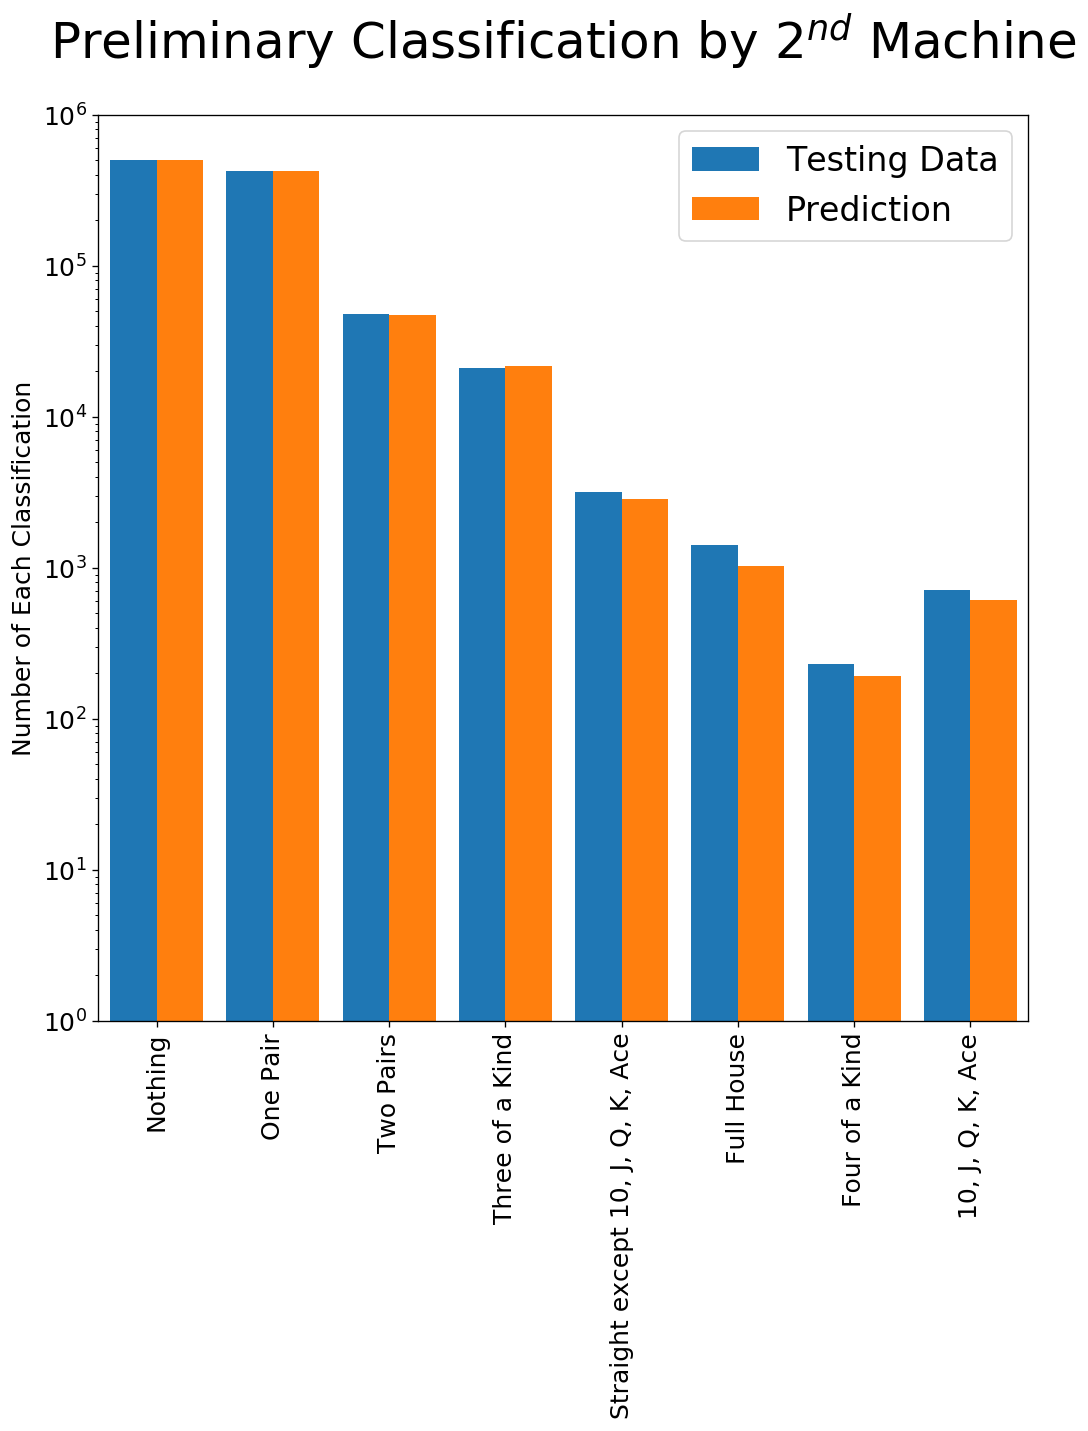

In [21]:
figure = plt.figure(figsize=(10,10), dpi=120)
ax = plt.hist([y_card_test, y_card_predict], bins=np.arange(-0.5,8.5,1.0), log=True, align='mid')
ax = plt.xlim(-.5,7.5,1.0)
ax = plt.ylim(1,1e6)
ticks = np.arange(0, 8, 1.0)
labels = ['Nothing','One Pair','Two Pairs', 'Three of a Kind', 'Straight except 10, J, Q, K, Ace', 'Full House', 'Four of a Kind', '10, J, Q, K, Ace']
ax = plt.xticks(ticks, labels, rotation = 'vertical',fontsize=15)
ax = plt.yticks(fontsize=15)
ax = plt.ylabel('Number of Each Classification', fontsize=15)
ax = plt.legend(['Testing Data','Prediction'], prop={'size': 20})
ax = plt.title('Preliminary Classification by $2^{nd}$ Machine', fontsize=30, y= 1.05)
plt.show()

### 利用花色把 Preliminary Classification 得到的 8 個分類還原成 10 個分類

In [22]:
y_predict = np.zeros((len(y_card_predict)))
for i in range(0,len(y_card_predict)):
    if y_card_predict[i] == 0:
        if y_test_flush[i] == 1:
            y_predict[i] = 5
        else:
            y_predict[i] = 0
    elif y_card_predict[i] == 4:
        if y_test_flush[i] == 0:
            y_predict[i] = 4
        else:
            y_predict[i] = 8
    elif y_card_predict[i] == 5:
        y_predict[i] = 6
    elif y_card_predict[i] == 6:
        y_predict[i] = 7
    elif y_card_predict[i] == 7:
        if y_test_flush[i] == 0:
            y_predict[i] = 4
        else:
            y_predict[i] = 9    
    else:
        y_predict[i] = y_card_predict[i]
        
# 0: Nothing 1: One Pair 2: Two Pairs 3: Three of a Kind 4: Straight except 10,J,Q,K,A 5: Full House 6:Four of a Kind 7: 10,J,Q,K,A
# -> convert to
# 0:Nothing Specical 1:One Pair 2:Two Pairs 3:Three of a Kind 4:Straight 5:Flush 6:Full House 7:Four of a Kind 8:Straight Flush 9:Royal Flush

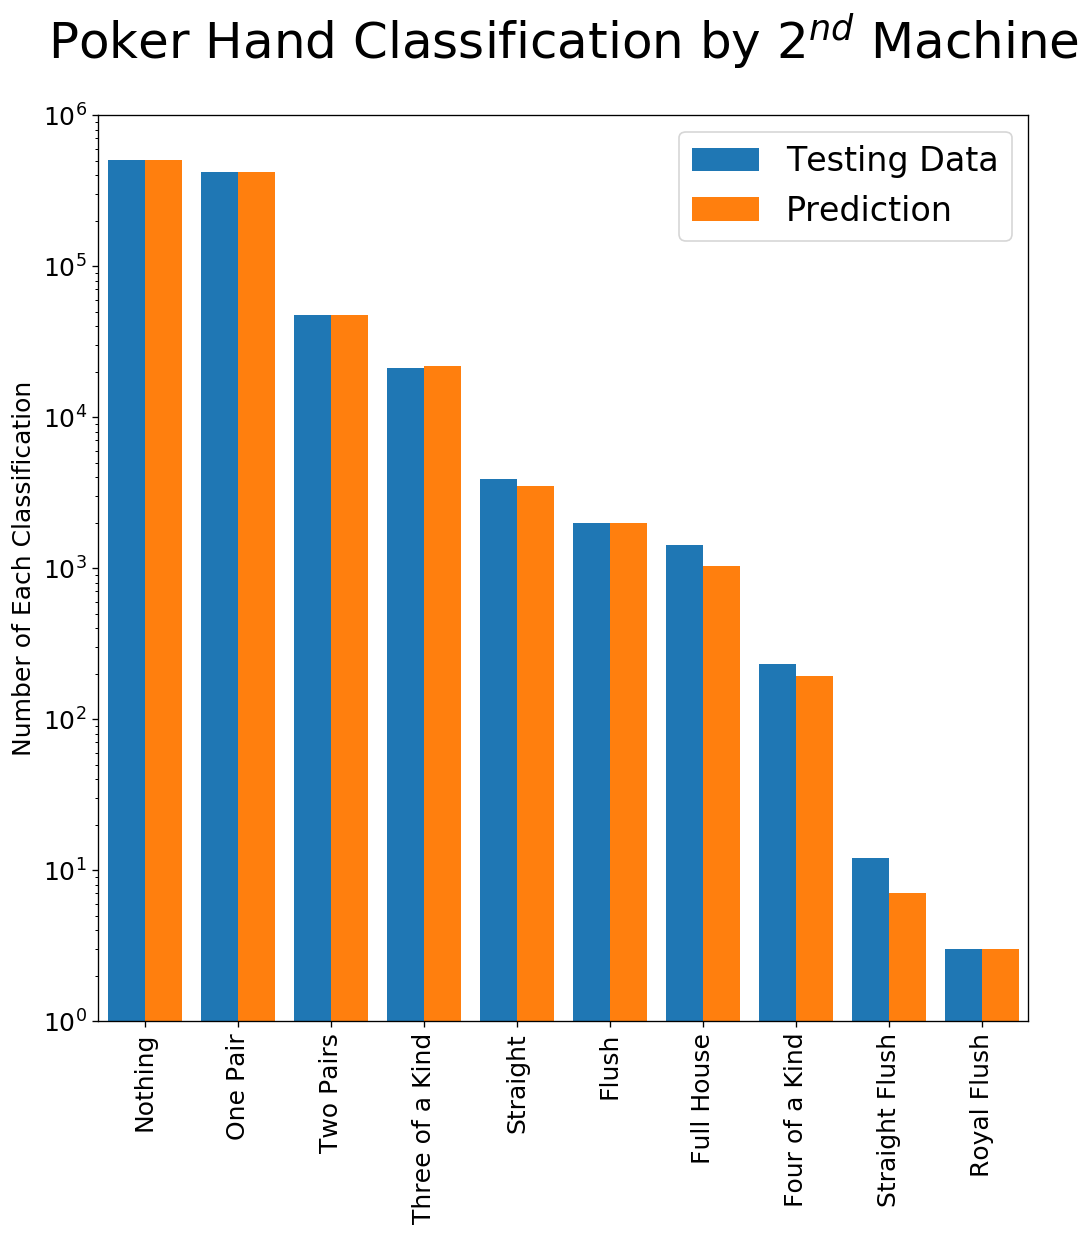

In [23]:
figure = plt.figure(figsize=(10,10), dpi=120)
ax = plt.hist([y_test, y_predict], bins=np.arange(-0.5,10.5,1.0), log=True, align='mid')
ax = plt.xlim(-.5,9.5,1.0)
ax = plt.ylim(1,1e6)
ticks = np.arange(0, 10, 1.0)
labels = ['Nothing','One Pair','Two Pairs', 'Three of a Kind', 'Straight', 'Flush', 'Full House', 'Four of a Kind', 'Straight Flush', 'Royal Flush']
ax = plt.xticks(ticks, labels, rotation = 'vertical', fontsize=15)
ax = plt.yticks(fontsize=15)
ax = plt.ylabel('Number of Each Classification', fontsize=15)
ax = plt.legend(['Testing Data','Prediction'], prop={'size': 20})
ax = plt.title('Poker Hand Classification by $2^{nd}$ Machine', fontsize=30, y= 1.05)
plt.show()

### 這 Histogram 看起來真不錯的說，而且連 Royal Flust 都對了!!

In [24]:
name_test = []
name_predict = []
for i in range(0,len(y_test)):
    name_test.append(category[y_test[i]])
    name_predict.append(category[y_predict[i]])
name_test = np.array(name_test)
name_predict = np.array(name_predict)

pd.crosstab(name_test, name_predict, rownames=['true classification'],colnames=['predict classification'])

predict classification,0. Nothing,1. One Pair,2. Two Pairs,3. Three of a Kind,4. Straight,5. Flush,6. Full House,7. Four of a Kind,8. Straight Flush,9. Royal Flush
true classification,,,,,,,,,,
0. Nothing,501139,12,0,0,58,0,0,0,0,0
1. One Pair,0,422201,0,0,297,0,0,0,0,0
2. Two Pairs,0,285,46857,454,0,0,0,26,0,0
3. Three of a Kind,0,7,249,20627,0,0,78,160,0,0
4. Straight,352,415,0,0,3118,0,0,0,0,0
5. Flush,0,0,0,0,0,1996,0,0,0,0
6. Full House,0,0,74,401,0,0,949,0,0,0
7. Four of a Kind,0,0,0,221,0,0,3,6,0,0
8. Straight Flush,0,2,0,0,0,0,0,0,7,3


### 然後看了 confusion matrix 才發現一切都是假的，Full House, Straight Flush認錯快一半，樣本數少的 Four of a Kind也不甚理想， Royal Flush 掛蛋。不過非對角線元素較方法一少了頗多。 

In [25]:
#model_2nd_json = model_2nd.to_json()
#open('./Poker_Hand_Machines/poker_hand_2nd_machine','w').write(model_2nd_json)
#model_2nd.save_weights('./Poker_Hand_Machines/poker_hand_2nd_machine_weights.h5')

## 方法三: 在方法二的基礎上，多加一些特徵再做訓練，看看有沒有機會學得更好
### 這次我們試著用Functional API做一個合併的神經網路:<br>
先訓練機器從 x_card_train 的數字組合看出三個特徵:<br>
&emsp;&emsp;1.最多有幾張數字是一樣的<br>
&emsp;&emsp;2.有幾組牌數字是一樣的(每組的成員要大於1)<br>
&emsp;&emsp;3.數字最大跟最小的牌的數字差值<br><br>
其實只要準確地知道 1 跟 2，一副牌到底是:<br>
One Pair (2,1),<br>
Two Pairs (2,2),<br>
Three of a Kind (3,1),<br>
Full House (3,2),<br>
Four of a Kind (4,1), 或是<br>
Striaght(含 \[10, J, Q, K, A\] )+Nothing (0,0)<br>
其中哪種類別就能完全決定，而第三點則是用來把 Straight (差值是 4 ), \[10, J, Q, K, A\] (差值是 12 ) 跟 Nothing (差值不一定，會含到 4 跟 12，可是總體應該很隨機) 做一些區隔，雖然沒辦法完全分開。但就算用訓練資料訓練過後，神經網路應該還是沒辦法完全準確地猜中這三個特徵，加上還需要把Straight, \[10, J, Q, K, A\] 跟 Nothing 分開，我們決定把這些特徵跟 x_card_test_normalized 合併，再去做最後一部份的訓練(最後的網路跟之前一樣，都是兩層 400 個 Dense layer，再 output 成 8 個特徵)。

### 把 testing data 和 training data的三種特徵標記好，寫成 y_new_character_test 跟 y_new_character_train

In [26]:
y_new_character_train = np.zeros((len(x_train),3))
y_new_character_test = np.zeros((len(x_test),3))

for i in range(0,len(y_train)):
    y_new_character_train[i,0] = x_card_train_normalized[i].max()-x_card_train_normalized[i].min()
    if y_card_train[i] == 1:    # One Pair
        y_new_character_train[i,1] = 2
        y_new_character_train[i,2] = 1
    elif y_card_train[i] == 2:    # Two Pairs
        y_new_character_train[i,1] = 2
        y_new_character_train[i,2] = 2
    elif y_card_train[i] == 3:    # Three of a Kind
        y_new_character_train[i,1] = 3
        y_new_character_train[i,2] = 1
    elif y_card_train[i] == 5:    # Full House
        y_new_character_train[i,1] = 3
        y_new_character_train[i,2] = 2
    elif y_card_train[i] == 6:    # Four of a Kind
        y_new_character_train[i,1] = 4
        y_new_character_train[i,2] = 1
    
#    y_new_character_train[i,1] /= 4.0
#    y_new_character_train[i,2] /= 2.0
    
for i in range(0,len(y_test)):
    y_new_character_test[i,0] = x_card_test_normalized[i].max()-x_card_test_normalized[i].min()
    if y_card_test[i] == 1:    # One Pair
        y_new_character_test[i,1] = 2
        y_new_character_test[i,2] = 1
    elif y_card_test[i] == 2:    # Two Pairs
        y_new_character_test[i,1] = 2
        y_new_character_test[i,2] = 2
    elif y_card_test[i] == 3:    # Three of a Kind
        y_new_character_test[i,1] = 3
        y_new_character_test[i,2] = 1
    elif y_card_test[i] == 5:    # Full House
        y_new_character_test[i,1] = 3
        y_new_character_test[i,2] = 2
    elif y_card_test[i] == 6:    # Four of a Kind
        y_new_character_test[i,1] = 4
        y_new_character_test[i,2] = 1
        
#        y_new_character_test[i,1] /= 4.0
#        y_new_character_test[i,2] /= 2.0

### 開個空的機器並訓練
這邊 layer 跟前面不一樣，不是用 list 開，之後才能調 trainable 的布林值

In [27]:
model_3rd = Sequential()

first_layer_3 = Dense(100, input_dim = 5, activation ='relu')
second_layer_3 = Dense(100, activation ='relu')
output_layer_3 = Dense(3, activation ='softmax')

model_3rd = Sequential([first_layer_3 ,second_layer_3, output_layer_3])

model_3rd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 303       
Total params: 11,003
Trainable params: 11,003
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_3rd.load_weights('./Poker_Hand_Machines/poker_hand_3rd_machine_weights.h5')
model_3rd.compile(optimizers.sgd(lr=0.1), loss = losses.mse, metrics = ['acc'])
#model_3rd_histroy = model_3rd.fit(x_card_train_normalized,y_new_character_train, batch_size=100, epochs=1000)

In [29]:
y_new_character_predict = model_3rd.predict(x_card_test_normalized)
score_new_character_train = model_3rd.evaluate(x_card_train_normalized, y_new_character_train)
score_new_charactre_predict = model_3rd.evaluate(x_card_test_normalized, y_new_character_test)

1000000/1000000 [==============================] - 14s 14us/step


In [30]:
print(f'For Training Data: Loss = {score_card_train[0]:.6f}; Accuracy = {100*score_card_train[1]:.6f}%')
print(f'For Testing Data: Loss = {score_card_predict[0]:.6f}; Accuracy = {100*score_card_predict[1]:.6f}%')

For Training Data: Loss = 0.006536; Accuracy = 99.984006%
For Testing Data: Loss = 0.017602; Accuracy = 99.676400%


In [31]:
#model_3rd_json = model_3rd.to_json()
#open('./Poker_Hand_Machines/poker_hand_3rd_machine','w').write(model_3rd_json)
#model_3rd.save_weights('./Poker_Hand_Machines/poker_hand_3rd_machine_weights.h5')

### 有嘗試過把 Model_3rd 訓練後得到的值固定，可是發現效果沒把 trainable 打開來得好

In [32]:
for layer in [first_layer_3 ,second_layer_3, output_layer_3]:
#    layer.trainable = False
    layer.trainable = True

### 用 Functional API 架構神經網路

In [33]:
x = Input(shape=(5,))

first_layer_api = Dense(400, input_dim=8, activation='relu')
second_layer_api = Dense(400, activation = 'relu')
output_layer_api = Dense(8, activation = 'softmax')

In [34]:
x1 = first_layer_3(x)
x2 = second_layer_3(x1)
y_new = output_layer_3(x2)
u = concatenate([y_new,x])
y1 = first_layer_api(u)
y2 = second_layer_api(y1)
y = output_layer_api(y2)


In [35]:
model_4th = Model(x,y)
model_4th.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 100)          600         input_1[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 100)          10100       dense_7[1][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 3)            303         dense_8[1][0]                    
__________________________________________________________________________________________________
concatenat

In [36]:
model_4th.load_weights('./Poker_Hand_Machines/poker_hand_4th_machine_weights.h5')
model_4th.compile(optimizers.sgd(lr=0.2), loss = losses.categorical_crossentropy, metrics = ['acc'])
#model_4th.fit(x_card_train_normalized, y_card_train_one_hot, batch_size=100, epochs=750)

In [37]:
y_card_predict_one_hot = model_4th.predict(x_card_test_normalized)
score_card_train = model_4th.evaluate(x_card_train_normalized, y_card_train_one_hot)
score_card_predict = model_4th.evaluate(x_card_test_normalized, y_card_test_one_hot)

1000000/1000000 [==============================] - 44s 44us/step


In [38]:
print(f'For Training Data: Loss = {score_card_train[0]:.6f}; Accuracy = {100*score_card_train[1]:.6f}%')
print(f'For Testing Data: Loss = {score_card_predict[0]:.6f}; Accuracy = {100*score_card_predict[1]:.6f}%')

For Training Data: Loss = 0.000246; Accuracy = 99.996002%
For Testing Data: Loss = 0.005536; Accuracy = 99.873500%


In [39]:
#model_4th_json = model_4th.to_json()
#open('./Poker_Hand_Machines/poker_hand_4th_machine','w').write(model_4th_json)
#model_4th.save_weights('./Poker_Hand_Machines/poker_hand_4th_machine_weights.h5')

In [40]:
for i in range(0, len(y_test)):
    y_card_predict[i] = y_card_predict_one_hot[i].argmax()     #"one-hot decode"
#y_card_predict

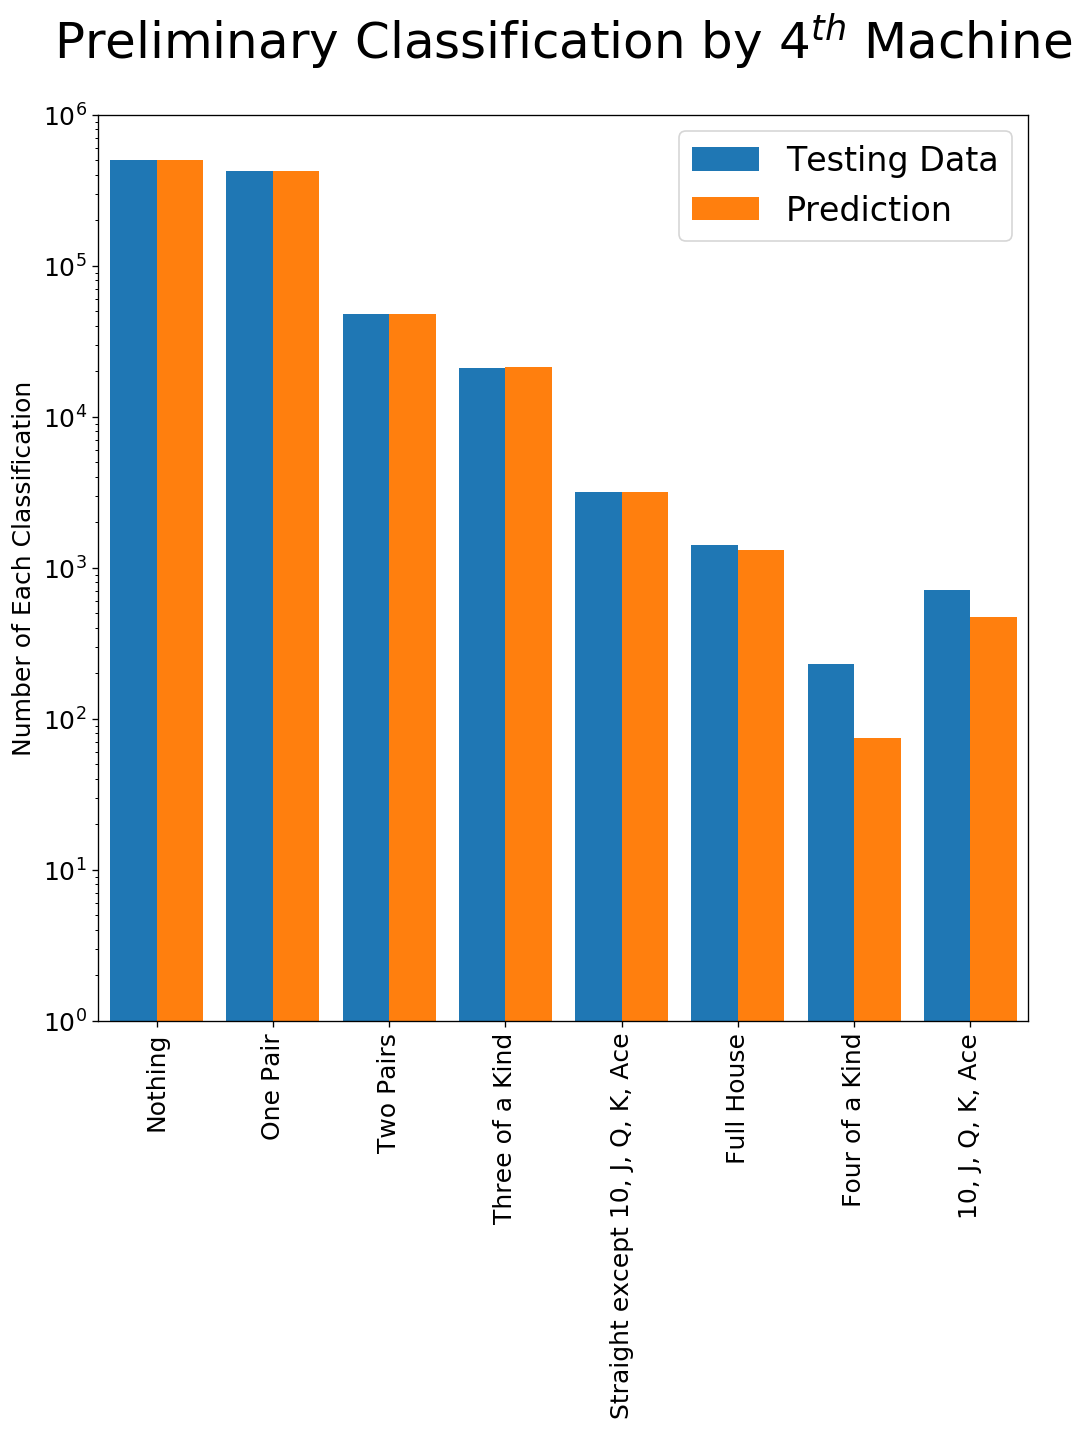

In [41]:
figure = plt.figure(figsize=(10,10), dpi=120)
ax = plt.hist([y_card_test, y_card_predict], bins=np.arange(-0.5,8.5,1.0), log=True, align='mid')
ax = plt.xlim(-.5,7.5,1.0)
ax = plt.ylim(1,1e6)
ticks = np.arange(0, 8, 1.0)
labels = ['Nothing','One Pair','Two Pairs', 'Three of a Kind', 'Straight except 10, J, Q, K, Ace', 'Full House', 'Four of a Kind', '10, J, Q, K, Ace']
ax = plt.xticks(ticks, labels, rotation = 'vertical',fontsize=15)
ax = plt.yticks(fontsize=15)
ax = plt.ylabel('Number of Each Classification', fontsize=15)
ax = plt.legend(['Testing Data','Prediction'], prop={'size': 20})
ax = plt.title('Preliminary Classification by $4^{th}$ Machine', fontsize=30, y= 1.05)
plt.show()

### 用花色把 8 個分類還原成 10 個

In [42]:
y_predict = np.zeros((len(y_card_predict)))
for i in range(0,len(y_card_predict)):
    if y_card_predict[i] == 0:
        if y_test_flush[i] == 1:
            y_predict[i] = 5
        else:
            y_predict[i] = 0
    elif y_card_predict[i] == 4:
        if y_test_flush[i] == 0:
            y_predict[i] = 4
        else:
            y_predict[i] = 8
    elif y_card_predict[i] == 5:
        y_predict[i] = 6
    elif y_card_predict[i] == 6:
        y_predict[i] = 7
    elif y_card_predict[i] == 7:
        if y_test_flush[i] == 0:
            y_predict[i] = 4
        else:
            y_predict[i] = 9    
    else:
        y_predict[i] = y_card_predict[i]
        
# 0: Nothing 1: One Pair 2: Two Pairs 3: Three of a Kind 4: Straight except 10,J,Q,K,A 5: Full House 6:Four of a Kind 7: 10,J,Q,K,A
# -> convert to
# 0:Nothing Specical 1:One Pair 2:Two Pairs 3:Three of a Kind 4:Straight 5:Flush 6:Full House 7:Four of a Kind 8:Straight Flush 9:Royal Flush

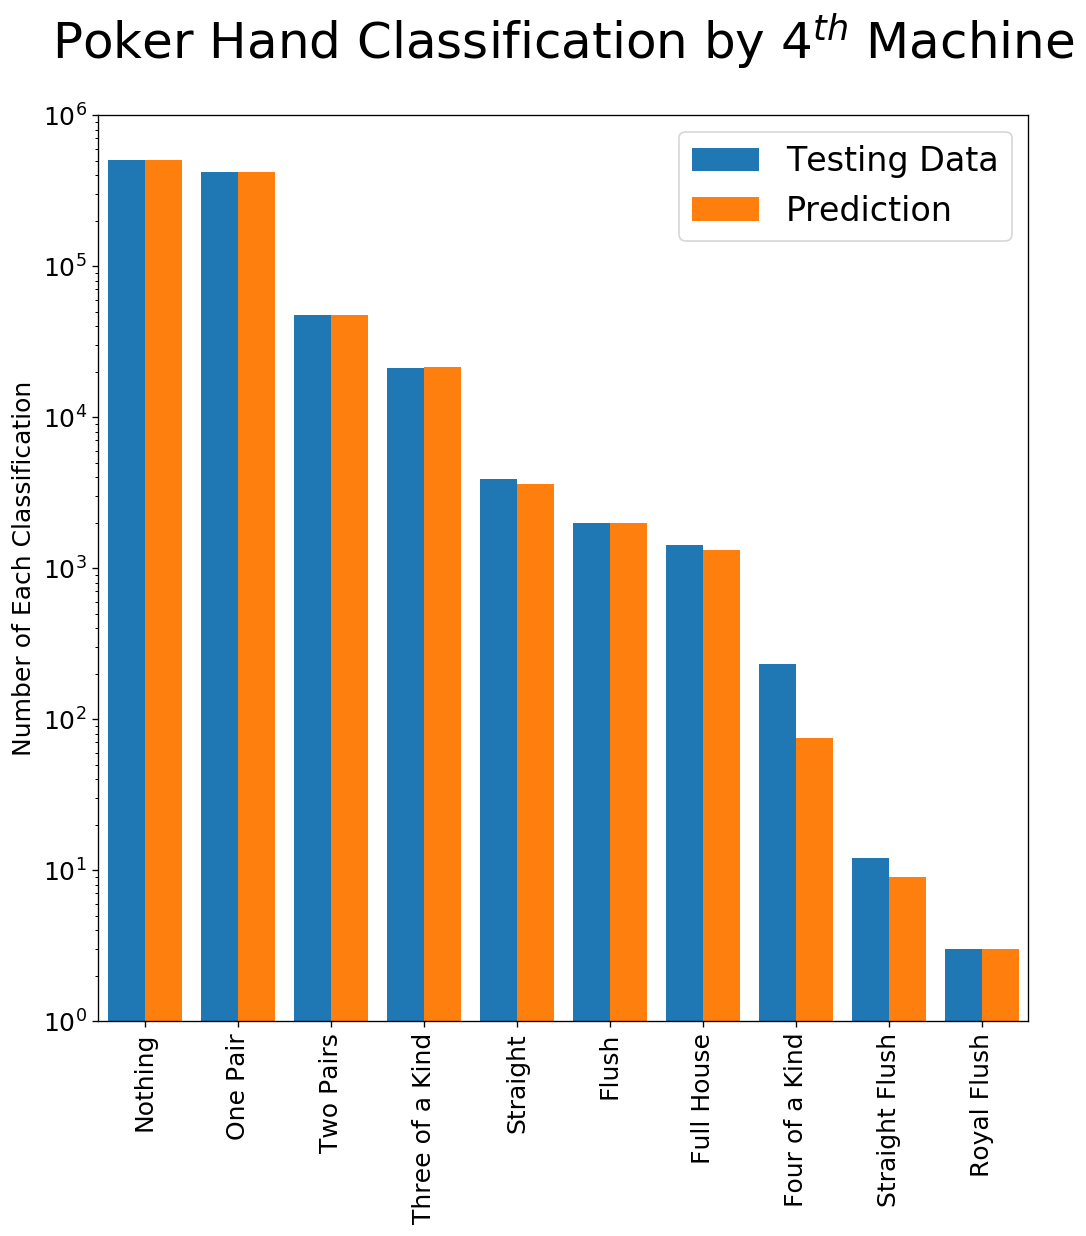

In [43]:
figure = plt.figure(figsize=(10,10), dpi=120)
ax = plt.hist([y_test, y_predict], bins=np.arange(-0.5,10.5,1.0), log=True, align='mid')
ax = plt.xlim(-.5,9.5,1.0)
ax = plt.ylim(1,1e6)
ticks = np.arange(0, 10, 1.0)
labels = ['Nothing','One Pair','Two Pairs', 'Three of a Kind', 'Straight', 'Flush', 'Full House', 'Four of a Kind', 'Straight Flush', 'Royal Flush']
ax = plt.xticks(ticks, labels, rotation = 'vertical', fontsize=15)
ax = plt.yticks(fontsize=15)
ax = plt.ylabel('Number of Each Classification', fontsize=15)
ax = plt.legend(['Testing Data','Prediction'], prop={'size': 20})
ax = plt.title('Poker Hand Classification by $4^{th}$ Machine', fontsize=30, y= 1.05)
plt.show()

In [44]:
name_test = []
name_predict = []
for i in range(0,len(y_test)):
    name_test.append(category[y_test[i]])
    name_predict.append(category[y_predict[i]])
name_test = np.array(name_test)
name_predict = np.array(name_predict)

pd.crosstab(name_test, name_predict, rownames=['true classification'],colnames=['predict classification'])

predict classification,0. Nothing,1. One Pair,2. Two Pairs,3. Three of a Kind,4. Straight,5. Flush,6. Full House,7. Four of a Kind,8. Straight Flush,9. Royal Flush
true classification,,,,,,,,,,
0. Nothing,501119,5,0,0,85,0,0,0,0,0
1. One Pair,0,422495,3,0,0,0,0,0,0,0
2. Two Pairs,0,2,47554,66,0,0,0,0,0,0
3. Three of a Kind,0,0,30,21026,0,0,60,5,0,0
4. Straight,348,2,0,0,3535,0,0,0,0,0
5. Flush,0,0,0,0,0,1996,0,0,0,0
6. Full House,0,0,2,287,0,0,1118,17,0,0
7. Four of a Kind,0,0,0,47,0,0,130,53,0,0
8. Straight Flush,0,0,0,0,0,1,0,0,9,2


### 可以看到雖然表面上 Histogram 不如 2<sup>nd</sup> Machine 來得好，可是實際上 confusion matrix 非對角線的元素更少了， One Pair 幾乎正確地被分類， Two Pairs 的錯誤率也頗低，Three of a Kind, Straight, Full House 的正確率也明顯提高， Straigh Flush 多對了兩個， 連 Royal Flush也對了一個 XD

### 可是回頭看看 3<sup>rd</sup> Machine training data 的正確率，發現他變得六親不認了。所以感覺這個神經網路並不是真正再看本來想要用的那三個特徵做分類的說 @w@a

In [45]:
score_new_character_train = model_3rd.evaluate(x_card_train_normalized, y_new_character_train)
print(score_new_character_train[1])

25010/25010 [==============================] - 0s 17us/step
0.5402638944422231


## 心得
感覺這筆資料不是那麼好分類的說，雖然三個方法的正確率都有97%以上，但真正難分類的是那些樣本數很少的資料，像 Full Hose, Four of a Kind, Royal Flush 之類的，所以很高的 accuracy 可能只要沒事猜 Nothing, One Pair , Two Pairs 就可以達到。為了分類那些少數樣本而加上的特徵，感覺有讓神經網路看 One Pair, Two Pair 跟 Three of a Kind 更準，可是 Straight 方面的特徵感覺還不夠，所以跟 Straight 有關的分類感覺不是很準，另外 Four of a Kind 也不太準(好像都會被認成Full House)，這個我就想不太到原因了QQ
